# Initialize

In [49]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchinfo import summary

from models.Transformer import ViTforEEG
from prepare_data import get_raw_dataloader, get_sub1_dataloader, get_frequency_dataloader, get_time_series_dataloader
from utils.training import best_torch_device, train

In [15]:
# torch.manual_seed(3407)
torch.manual_seed(0)
np.random.seed(0)

In [16]:
%load_ext autoreload
%autoreload 2

## Constants

In [17]:
DEVICE = best_torch_device()
RAW = "raw"
SUB1 = "sub1"
FREQ = "frequency"

## Load Data

In [18]:
train_data = {}
valid_data = {}
test_data = {}

### Raw Data

In [19]:
train_data[RAW], valid_data[RAW], test_data[RAW] = get_raw_dataloader()

In [20]:
print("Training set shape:", train_data[RAW].dataset.X.shape)
print("Validation set shape:", valid_data[RAW].dataset.X.shape)
print("Test set shape:", test_data[RAW].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


### Sub1 Data

In [21]:
train_data[SUB1], valid_data[SUB1], test_data[SUB1] = get_sub1_dataloader()

In [22]:
print("Training set shape:", train_data[SUB1].dataset.X.shape)
print("Validation set shape:", valid_data[SUB1].dataset.X.shape)
print("Test set shape:", test_data[SUB1].dataset.X.shape)

Training set shape: (199, 22, 1000)
Validation set shape: (38, 22, 1000)
Test set shape: (50, 22, 1000)


### Frequency Data

In [23]:
train_data[FREQ], valid_data[FREQ], test_data[FREQ] = get_frequency_dataloader()

In [24]:
print("Training set shape:", train_data[FREQ].dataset.X.shape)
print("Validation set shape:", valid_data[FREQ].dataset.X.shape)
print("Test set shape:", test_data[FREQ].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


# Model

In [25]:
test_model = ViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      n_patches=500,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)
test_model.forward(torch.rand(2, 22, 1000))
summary(test_model, input_size=(1, 22, 1000), device=DEVICE)

Layer (type:depth-idx)                        Output Shape              Param #
ViTforEEG                                     [1, 4]                    64
├─Linear: 1-1                                 [1, 500, 64]              2,880
├─TransformerEncoder: 1-2                     [1, 501, 64]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 501, 64]              25,216
├─Sequential: 1-3                             [1, 4]                    --
│    └─Linear: 2-2                            [1, 4]                    260
│    └─Softmax: 2-3                           [1, 4]                    --
Total params: 28,420
Trainable params: 28,420
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.09
Forward/backward pass size (MB): 0.26
Params size (MB): 0.01
Estimated Total Size (MB): 0.36

# Training

## Raw Data
Train on raw data, evaluate on raw data

In [80]:
raw_model = ViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      n_patches=500,
                      hidden_dims=128,
                      num_heads=16,
                      ff_dim=128,
                      dropout=0.3,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[RAW],
    val_data=valid_data[RAW],
    early_stopping_patience=50,
    cp_path="models/transformer",
    cp_filename="raw.pt",
    n_epochs=300,
    show_progress_bar=False,
)

Using device: cuda
[Epoch 0] val_acc=0.266272 train_acc=0.247046 val_loss=0.024515 train_loss=0.021983
Validation loss decreased (inf --> 0.024515).  Saving model ...
[Epoch 1] val_acc=0.266272 train_acc=0.267867 val_loss=0.024507 train_loss=0.021843
Validation loss decreased (0.024515 --> 0.024507).  Saving model ...
[Epoch 2] val_acc=0.251479 train_acc=0.261114 val_loss=0.024464 train_loss=0.021856
Validation loss decreased (0.024507 --> 0.024464).  Saving model ...
[Epoch 3] val_acc=0.269231 train_acc=0.276871 val_loss=0.024651 train_loss=0.021868
EarlyStopping counter: 1 out of 50
[Epoch 4] val_acc=0.257396 train_acc=0.257175 val_loss=0.024565 train_loss=0.021863
EarlyStopping counter: 2 out of 50
[Epoch 5] val_acc=0.278107 train_acc=0.270681 val_loss=0.024561 train_loss=0.021828
EarlyStopping counter: 3 out of 50
[Epoch 6] val_acc=0.275148 train_acc=0.283061 val_loss=0.024705 train_loss=0.021797
EarlyStopping counter: 4 out of 50
[Epoch 7] val_acc=0.281065 train_acc=0.281936 val_l

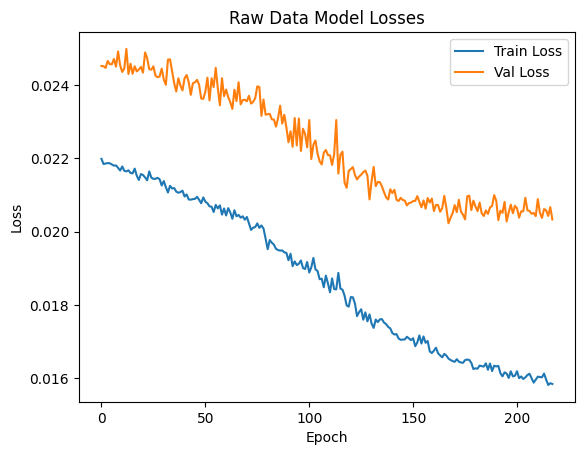

In [81]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

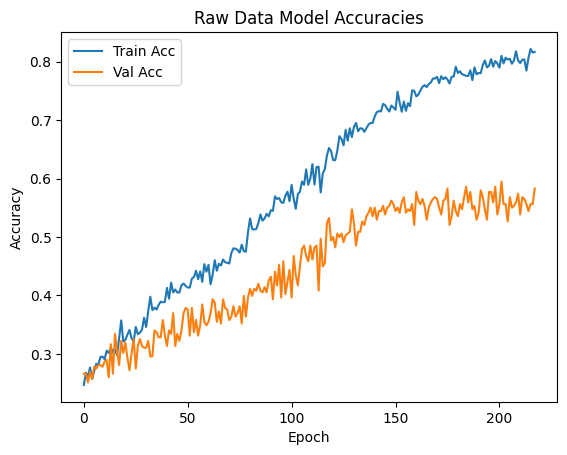

In [82]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [83]:
# Load best model and test
raw_model = torch.load("models/transformer/raw.pt")
raw_model.to(DEVICE)
raw_model.eval()

ViTforEEG(
  (lin_emb): Linear(in_features=44, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [84]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.5576


In [86]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.4600


## Subject 1 Only    

In [87]:
sub1_model = ViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      n_patches=500,
                      hidden_dims=128,
                      num_heads=16,
                      ff_dim=128,
                      dropout=0.3,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(sub1_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=sub1_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[SUB1],
    val_data=valid_data[SUB1],
    early_stopping_patience=50,
    cp_path="models/transformer",
    cp_filename="sub1.pt",
    n_epochs=300,
    show_progress_bar=False,
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: cuda
[Epoch 0] val_acc=0.210526 train_acc=0.246231 val_loss=0.037280 train_loss=0.028178
Validation loss decreased (inf --> 0.037280).  Saving model ...
[Epoch 1] val_acc=0.236842 train_acc=0.271357 val_loss=0.036953 train_loss=0.028239
Validation loss decreased (0.037280 --> 0.036953).  Saving model ...
[Epoch 2] val_acc=0.263158 train_acc=0.281407 val_loss=0.036588 train_loss=0.027871
Validation loss decreased (0.036953 --> 0.036588).  Saving model ...
[Epoch 3] val_acc=0.289474 train_acc=0.296482 val_loss=0.036511 train_loss=0.027836
Validation loss decreased (0.036588 --> 0.036511).  Saving model ...
[Epoch 4] val_acc=0.236842 train_acc=0.256281 val_loss=0.036945 train_loss=0.027945
EarlyStopping counter: 1 out of 50
[Epoch 5] val_acc=0.236842 train_acc=0.296482 val_loss=0.036833 train_loss=0.028320
EarlyStopping counter: 2 out of 50
[Epoch 6] val_acc=0.210526 train_acc=0.316583 val_loss=0.036846 train_loss=0.028233
EarlyStopping counter: 3 out of 50
[Epoch 7] val_acc

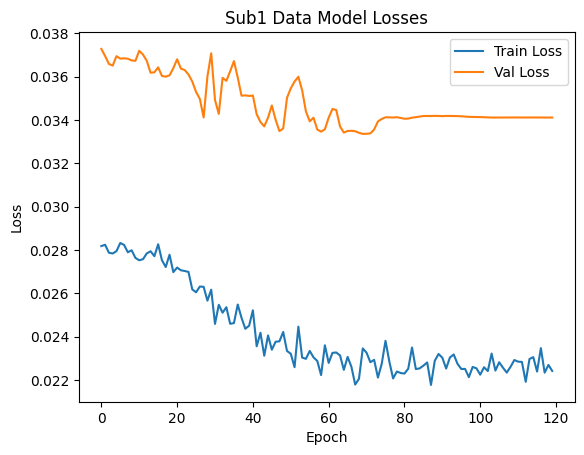

In [88]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

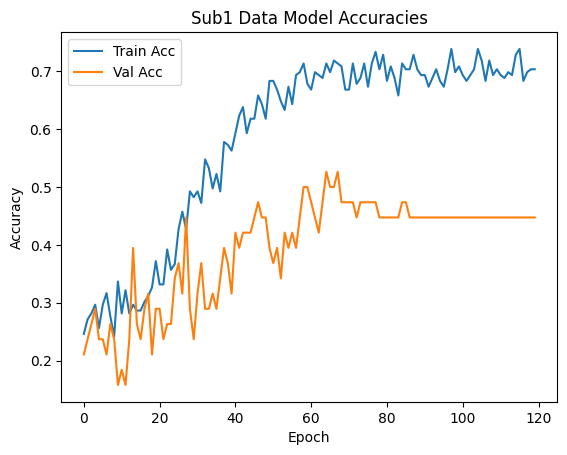

In [89]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [90]:
# Load best model and test
sub1_model = torch.load("models/transformer/sub1.pt")
sub1_model.to(DEVICE)
sub1_model.eval()

ViTforEEG(
  (lin_emb): Linear(in_features=44, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [91]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.2400


In [92]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on sub1 data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on raw data
Test Acc: 0.2438


## Frequency Filtering Data

In [93]:
freq_model = ViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      n_patches=500,
                      hidden_dims=128,
                      num_heads=16,
                      ff_dim=128,
                      dropout=0.3,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(freq_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=freq_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[FREQ],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/transformer",
    cp_filename="freq.pt",
    n_epochs=200,
    show_progress_bar=False,
)

Using device: cuda
[Epoch 0] val_acc=0.251479 train_acc=0.238604 val_loss=0.024679 train_loss=0.022050
Validation loss decreased (inf --> 0.024679).  Saving model ...
[Epoch 1] val_acc=0.215976 train_acc=0.244232 val_loss=0.024624 train_loss=0.021938
Validation loss decreased (0.024679 --> 0.024624).  Saving model ...
[Epoch 2] val_acc=0.263314 train_acc=0.249297 val_loss=0.024583 train_loss=0.021942
Validation loss decreased (0.024624 --> 0.024583).  Saving model ...
[Epoch 3] val_acc=0.242604 train_acc=0.248734 val_loss=0.024629 train_loss=0.021896
EarlyStopping counter: 1 out of 30
[Epoch 4] val_acc=0.272189 train_acc=0.245357 val_loss=0.024545 train_loss=0.021886
Validation loss decreased (0.024583 --> 0.024545).  Saving model ...
[Epoch 5] val_acc=0.266272 train_acc=0.257738 val_loss=0.024532 train_loss=0.021859
Validation loss decreased (0.024545 --> 0.024532).  Saving model ...
[Epoch 6] val_acc=0.266272 train_acc=0.251548 val_loss=0.024644 train_loss=0.021875
EarlyStopping coun

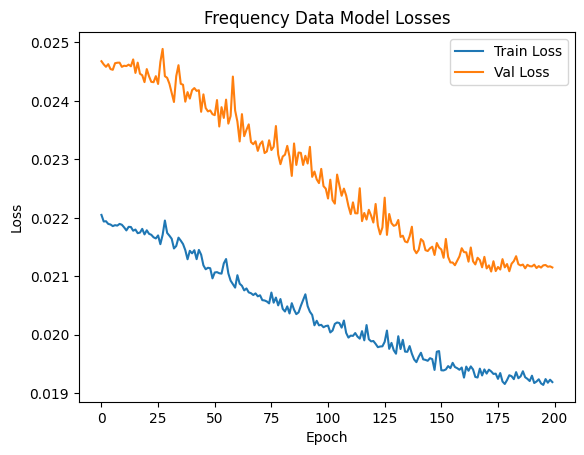

In [95]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Frequency Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

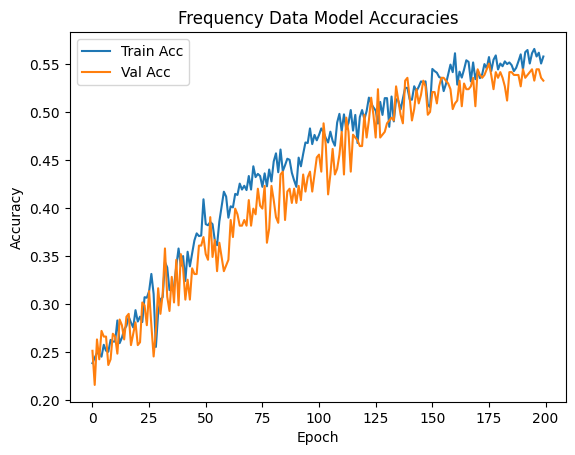

In [96]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Frequency Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [97]:
# Load best model and test
freq_model = torch.load("models/transformer/freq.pt")
freq_model.to(DEVICE)
freq_model.eval()

ViTforEEG(
  (lin_emb): Linear(in_features=44, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [98]:
# Evaluate on frequency data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = freq_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on frequency data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on frequency data, evaluate on raw data
Test Acc: 0.5056


## Time Series

In [99]:
time_slots = [50, 100, 150, 200, 250, 500, 750, 1000]

In [100]:
valid_acc = {}
test_acc = {}

for ts in time_slots:
    print(f"Training for time slots: {ts}...")

    train_data, valid_data, test_data = get_time_series_dataloader(ts)

    time_model = ViTforEEG(input_dim=(22, ts),
                      out_dim=4,
                      n_patches=ts//2,
                      hidden_dims=128,
                      num_heads=16,
                      ff_dim=128,
                      dropout=0.3,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)

    optimizer = torch.optim.Adam(time_model.parameters(), lr=0.001, weight_decay=1e-03)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    _ = train(
        model=time_model,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_func=nn.CrossEntropyLoss(),
        train_data=train_data,
        val_data=valid_data,
        early_stopping_patience=20,
        cp_path="models/transformer",
        cp_filename=f"time_{ts}.pt",
        n_epochs=150,
        show_progress_bar=False,
        verbose=False,
    )

    # Load best model and test
    time_model = torch.load(f"models/transformer/time_{ts}.pt")
    time_model.to(DEVICE)
    time_model.eval()

    # Evaluate validation accuracies
    valid_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            valid_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    valid_acc[ts] /= len(valid_data.dataset)

    # Evaluate test accuracies
    test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    test_acc[ts] /= len(test_data.dataset)

    print(f"Time slots: {ts}, Valid Acc: {valid_acc[ts]:.4f}, Test Acc: {test_acc[ts]:.4f}")

Training for time slots: 50...
Using device: cuda
Time slots: 50, Valid Acc: 0.3432, Test Acc: 0.3183
Training for time slots: 100...
Using device: cuda
Time slots: 100, Valid Acc: 0.4024, Test Acc: 0.4176
Training for time slots: 150...
Using device: cuda
Time slots: 150, Valid Acc: 0.3994, Test Acc: 0.3567
Training for time slots: 200...
Using device: cuda
Time slots: 200, Valid Acc: 0.5030, Test Acc: 0.4853
Training for time slots: 250...
Using device: cuda
Time slots: 250, Valid Acc: 0.5592, Test Acc: 0.5056
Training for time slots: 500...
Using device: cuda
Time slots: 500, Valid Acc: 0.5533, Test Acc: 0.4966
Training for time slots: 750...
Using device: cuda
Time slots: 750, Valid Acc: 0.5473, Test Acc: 0.5237
Training for time slots: 1000...
Using device: cuda
Time slots: 1000, Valid Acc: 0.4527, Test Acc: 0.4176


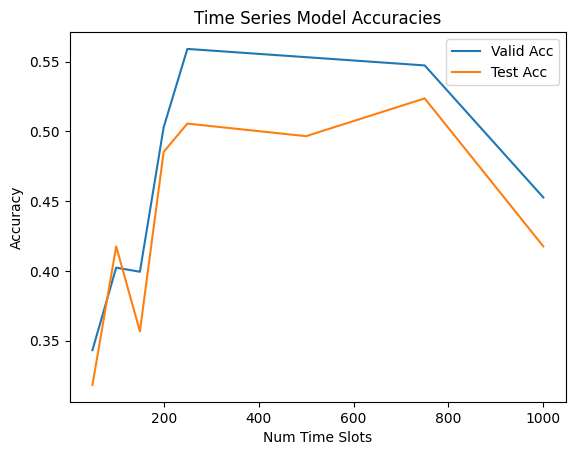

In [101]:
plt.plot(valid_acc.keys(), valid_acc.values(), label="Valid Acc")
plt.plot(test_acc.keys(), test_acc.values(), label="Test Acc")
plt.legend()
plt.title("Time Series Model Accuracies")
plt.xlabel("Num Time Slots")
plt.ylabel("Accuracy")
plt.show()